<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/5-deep-learning-for-computer-vision/3_using_pre_trained_convnet_for_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a pre-trained convnet for small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. 

A “few” samples can mean anywhere from a few hundred to a
few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

We’ll review one basic strategy to tackle this problem: **training a new model from scratch using what little data you have**. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. 

This will get you to a classification accuracy of 71%. At
that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation you’ll improve the network to reach an accuracy of 82%.

We’ll review two more essential techniques for applying deep
learning to small datasets: 
* **feature extraction with a pretrained network** (which will get you to an accuracy of 90% to 96%) 
* and **fine-tuning a pretrained network** (this will get you to a final accuracy of 97%). 

Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

Reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very highdimensional, like images.



## Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data).

<img src='https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg?raw=1' width='800'/>

Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train
your models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

Let's donload datasets from Kaggle.

In [2]:
# reference: https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
# Install Kaggle library
! pip install -q kaggle

     |████████████████████████████████| 122kB 2.7MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [3]:
# Try to downlaod data for the dogs-vs-cats challenge, it will fail.
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
# copy kaggle.json file to .kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Now try to downlaod data for the dogs-vs-cats challenge, it will succeed
!kaggle competitions download -c dogs-vs-cats

 97% 528M/543M [00:03<00:00, 160MB/s]
100% 543M/543M [00:03<00:00, 166MB/s]
 99% 268M/271M [00:02<00:00, 100MB/s]
100% 271M/271M [00:02<00:00, 115MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 12.0MB/s]


### Copying images to training, validation, and test directories

In [0]:
import os, shutil
import zipfile

In [0]:
# path to the directory where the original dataset was uncompressed
original_dataset_dir = 'kaggle_original_data'
# directory where we will store our smaller dataset
base_dir = 'cats_and_dogs_small'

# remove directories if it already exists
shutil.rmtree(original_dataset_dir, ignore_errors=True)
shutil.rmtree(base_dir, ignore_errors=True)

# create directories
os.mkdir(original_dataset_dir)
os.mkdir(base_dir)

In [0]:
# unzip train dataset
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

# unzip test dataset
with zipfile.ZipFile("test1.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

In [0]:
# create directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# create directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# create directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# create directory with our test cat/dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [10]:
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog  images: {len(os.listdir(train_dogs_dir))}')
print(f'total validation  cat images: {len(os.listdir(validation_cats_dir))}')
print(f'total validation  dog images: {len(os.listdir(validation_dogs_dir))}')
print(f'total test cat images: {len(os.listdir(test_cats_dir))}')
print(f'total test dog images: {len(os.listdir(test_dogs_dir))}')

total training cat images: 1000
total training dog  images: 1000
total validation  cat images: 500
total validation  dog images: 500
total test cat images: 500
total test dog images: 500


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

<img src='https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png?raw=1' width='800'/>

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. 

The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. 

On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. 

Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. 

For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). 

So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the keras.applications module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of keras.applications:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [11]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


We passed three arguments to the constructor:

* weights, to specify which weight checkpoint to initialize the model from
* include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
* input_shape, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

* Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of conv_base on our data and using these outputs as inputs to a new model.

### Fast Feature Extraction without Data Augmentation

We will start by simply running instances of the previously-introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the conv_base model.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1. / 255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))

  generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size: (i + 1) * batch_size] = features_batch
    labels[i * batch_size: (i + 1) * batch_size] = labels_batch
    i += 1

    if i * batch_size >= sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break;
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [0]:
features_shape = 4 * 4 * 512

train_features = np.reshape(train_features, (2000, features_shape))
validation_features = np.reshape(validation_features, (1000, features_shape))
test_features = np.reshape(test_features, (1000, features_shape))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_dim=features_shape))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 665us/sample - loss: 0.5913 - accuracy: 0.6760 - val_loss: 0.4422 - val_accuracy: 0.8410
Epoch 2/30
2000/2000 [==============================] - 1s 351us/sample - loss: 0.4285 - accuracy: 0.8030 - val_loss: 0.3661 - val_accuracy: 0.8550
Epoch 3/30
2000/2000 [==============================] - 1s 336us/sample - loss: 0.3671 - accuracy: 0.8485 - val_loss: 0.3239 - val_accuracy: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 352us/sample - loss: 0.3239 - accuracy: 0.8665 - val_loss: 0.2980 - val_accuracy: 0.8940
Epoch 5/30
2000/2000 [==============================] - 1s 366us/sample - loss: 0.2977 - accuracy: 0.8820 - val_loss: 0.2993 - val_accuracy: 0.8690
Epoch 6/30
2000/2000 [==============================] - 1s 352us/sample - loss: 0.2634 - accuracy: 0.8985 - val_loss: 0.2706 - val_accuracy: 0.8920
Epoch 7/30
2000/2000 [==============================] - 1s 359us

Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

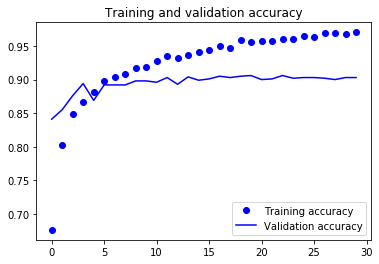

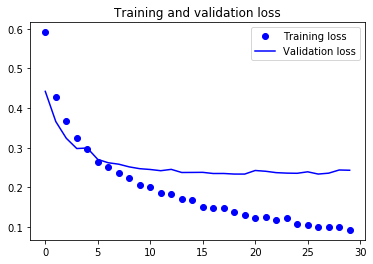

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

### Feature Extraction with Data Augmentation

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [0]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [19]:
print(f'This is the number of trainable weights before freezing the conv base:{len(model.trainable_weights)}')

This is the number of trainable weights before freezing the conv base:30


In [0]:
conv_base.trainable = False

In [21]:
print(f'This is the number of trainable weights after freezing the conv base:{len(model.trainable_weights)}')

This is the number of trainable weights after freezing the conv base:4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# https://stackoverflow.com/questions/55141076/how-to-apply-data-augmentation-in-tensorflow-2-0-after-tfds-load
# https://stackoverflow.com/questions/55421290/tensorflow-2-0-keras-how-to-write-image-summaries-for-tensorboard/55754700#55754700
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir,  # target directory
                                                    target_size=(150, 150), # resized to 150x150
                                                    batch_size=20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,  # target directory
                                                    target_size=(150, 150), # resized to 150x150
                                                    batch_size=20,
                                                    class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

# train the model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 - 27s - loss: 0.5945 - accuracy: 0.6860 - val_loss: 0.4520 - val_accuracy: 0.8290
Epoch 2/30
100/100 - 26s - loss: 0.4889 - accuracy: 0.7820 - val_loss: 0.3708 - val_accuracy: 0.8600
Epoch 3/30
100/100 - 26s - loss: 0.4379 - accuracy: 0.7990 - val_loss: 0.3338 - val_accuracy: 0.8630
Epoch 4/30
100/100 - 26s - loss: 0.3996 - accuracy: 0.8290 - val_loss: 0.3102 - val_accuracy: 0.8790
Epoch 5/30
100/100 - 26s - loss: 0.3832 - accuracy: 0.8260 - val_loss: 0.2952 - val_accuracy: 0.8910
Epoch 6/30
100/100 - 26s - loss: 0.3738 - accuracy: 0.8355 - val_loss: 0.2868 - val_accuracy: 0.8870
Epoch 7/30
100/100 - 26s - loss: 0.3642 - accuracy: 0.8370 - val_loss: 0.2874 - val_accuracy: 0.8790
Epoch 8/30
100/100 - 26s - loss: 0.3484 - accuracy: 0.8465 - val_loss: 0.2737 - val_accuracy: 0.8930
Epoch 9/30
100/

Let's save our model.

In [0]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

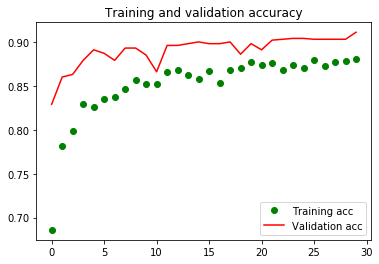

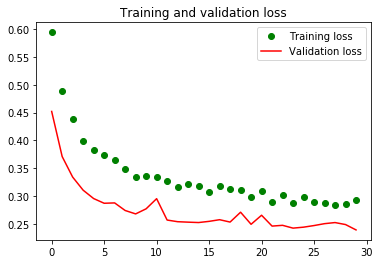

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning